In [43]:
from pathlib import Path
import random
import shutil
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import mlflow
import mlflow.pytorch

In [44]:
PROJECT_ROOT = Path.cwd()

RAW_DATA_DIR = PROJECT_ROOT / "data" / "images"
PREPARED_DATA_DIR = PROJECT_ROOT / "data" / "prepared"
MODELS_DIR = PROJECT_ROOT / "models"

MODELS_DIR.mkdir(exist_ok=True)

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [45]:
classes = sorted([d.name for d in RAW_DATA_DIR.iterdir() if d.is_dir()])
classes

['Белоспинный дятел',
 'Ворон',
 'Клёст-еловик',
 'Пёстрые дятлы',
 'Снегирь',
 'Уральская неясыть',
 'Чёрный коршун']

In [46]:
class_counts = {
    cls: len(list((RAW_DATA_DIR / cls).glob("*")))
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["num_images"]
)
df_counts

,num_images
Белоспинный дятел,329
Ворон,387
Клёст-еловик,397
Пёстрые дятлы,1
Снегирь,356
Уральская неясыть,212
Чёрный коршун,311


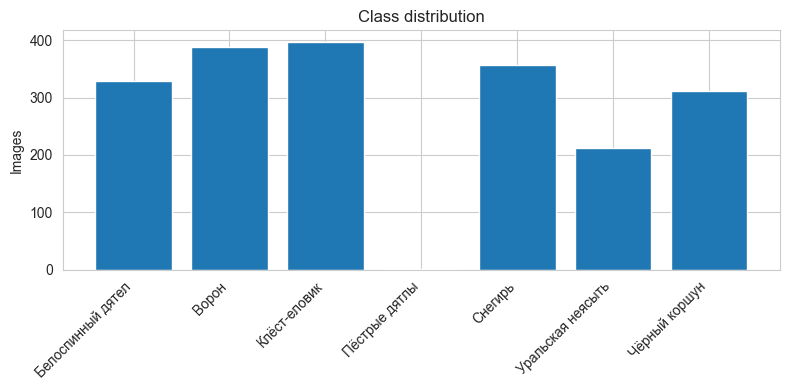

In [47]:
plt.figure(figsize=(8,4))
plt.bar(df_counts.index, df_counts["num_images"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Images")
plt.title("Class distribution")
plt.tight_layout()
plt.show()

In [48]:
MIN_IMAGES_PER_CLASS = 2

filtered_classes = [
    cls for cls, cnt in class_counts.items()
    if cnt >= MIN_IMAGES_PER_CLASS
]

removed_classes = [
    cls for cls, cnt in class_counts.items()
    if cnt < MIN_IMAGES_PER_CLASS
]

filtered_classes, removed_classes

(['Белоспинный дятел',
  'Ворон',
  'Клёст-еловик',
  'Снегирь',
  'Уральская неясыть',
  'Чёрный коршун'],
 ['Пёстрые дятлы'])

In [49]:
sizes = []

for cls in filtered_classes:
    for img_path in (RAW_DATA_DIR / cls).glob("*"):
        with Image.open(img_path) as img:
            sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df.describe()

,width,height
count,1992.000000,1992.000000
mean,460.544679,398.192771
std,60.897012,70.937526
min,225.000000,262.000000
25%,375.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,500.000000
max,500.000000,500.000000


In [63]:
if PREPARED_DATA_DIR.exists():
    shutil.rmtree(PREPARED_DATA_DIR)

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

for split in ["train", "val", "test"]:
    for cls in filtered_classes:
        (PREPARED_DATA_DIR / split / cls).mkdir(parents=True, exist_ok=True)

for cls in filtered_classes:
    images = list((RAW_DATA_DIR / cls).glob("*"))
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train+n_val],
        "test": images[n_train+n_val:]
    }

    for split, imgs in splits.items():
        for img in imgs:
            shutil.copy(img, PREPARED_DATA_DIR / split / cls / img.name)

    print(cls, {k: len(v) for k, v in splits.items()})

Белоспинный дятел {'train': 230, 'val': 49, 'test': 50}
Ворон {'train': 270, 'val': 58, 'test': 59}
Клёст-еловик {'train': 277, 'val': 59, 'test': 61}
Снегирь {'train': 249, 'val': 53, 'test': 54}
Уральская неясыть {'train': 148, 'val': 31, 'test': 33}
Чёрный коршун {'train': 217, 'val': 46, 'test': 48}


In [51]:
IMAGE_SIZE = 128

normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

train_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize
])
train_ds = datasets.ImageFolder(PREPARED_DATA_DIR / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(PREPARED_DATA_DIR / "val", transform=eval_tfms)
test_ds  = datasets.ImageFolder(PREPARED_DATA_DIR / "test", transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

num_classes = len(train_ds.classes)
train_ds.classes

['Белоспинный дятел',
 'Ворон',
 'Клёст-еловик',
 'Снегирь',
 'Уральская неясыть',
 'Чёрный коршун']

In [ ]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

In [52]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, p = torch.max(out, 1)

            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return accuracy_score(labels, preds), labels, preds

In [54]:
mlflow.set_experiment("bird_classification_experiments")

def train_experiment(lr, epochs):
    model = BirdCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []

    with mlflow.start_run():
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("image_size", IMAGE_SIZE)

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            train_losses.append(avg_loss)

            mlflow.log_metric("train_loss", avg_loss, step=epoch)

            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f}")

        acc, _, _ = evaluate(model, val_loader)
        mlflow.log_metric("val_accuracy", acc)

        plt.figure()
        plt.plot(range(1, epochs + 1), train_losses, marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")
        plt.title(f"Training Loss (lr={lr})")
        plt.grid(True)

        plot_path = f"loss_curve_lr_{lr}.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)

        plt.show()

    return acc

Epoch [1/10] | Loss: 3.4363
Epoch [2/10] | Loss: 1.8155
Epoch [3/10] | Loss: 1.8016
Epoch [4/10] | Loss: 1.6496
Epoch [5/10] | Loss: 1.4941
Epoch [6/10] | Loss: 1.3330
Epoch [7/10] | Loss: 1.3197
Epoch [8/10] | Loss: 1.2978
Epoch [9/10] | Loss: 1.1666
Epoch [10/10] | Loss: 1.1833


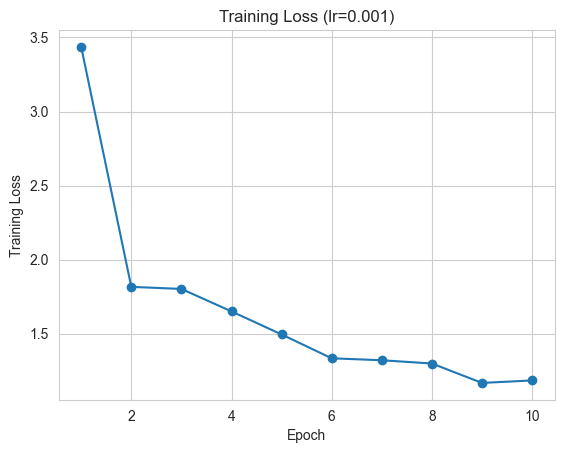

Epoch [1/10] | Loss: 2.4161
Epoch [2/10] | Loss: 1.6073
Epoch [3/10] | Loss: 1.4434
Epoch [4/10] | Loss: 1.3982
Epoch [5/10] | Loss: 1.2324
Epoch [6/10] | Loss: 1.1200
Epoch [7/10] | Loss: 1.0874
Epoch [8/10] | Loss: 1.0649
Epoch [9/10] | Loss: 1.0851
Epoch [10/10] | Loss: 1.0681


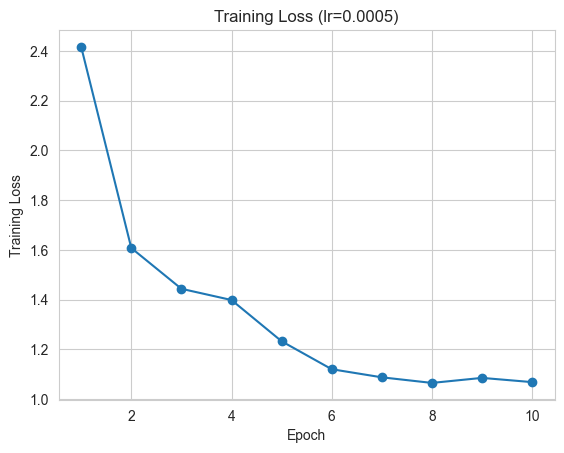

Epoch [1/10] | Loss: 1.6687
Epoch [2/10] | Loss: 1.4301
Epoch [3/10] | Loss: 1.2859
Epoch [4/10] | Loss: 1.2328
Epoch [5/10] | Loss: 1.1605
Epoch [6/10] | Loss: 1.0924
Epoch [7/10] | Loss: 1.0169
Epoch [8/10] | Loss: 0.9956
Epoch [9/10] | Loss: 0.9608
Epoch [10/10] | Loss: 0.9519


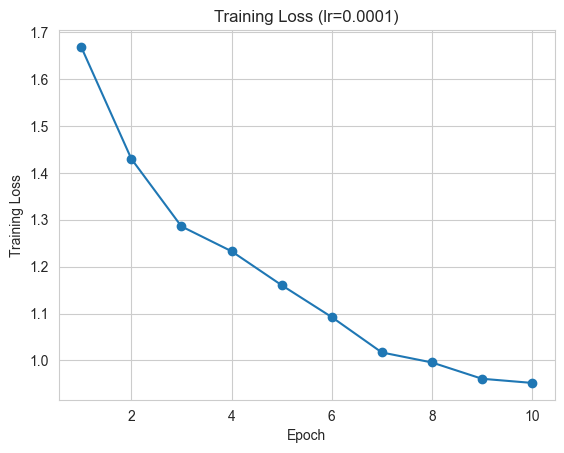

{0.001: 0.5371621621621622, 0.0005: 0.5304054054054054, 0.0001: 0.625}

In [55]:
results = {}

for lr in [1e-3, 5e-4, 1e-4]:
    acc = train_experiment(lr, epochs=10)
    results[lr] = acc

results

In [56]:
BEST_LR = max(results, key=results.get)
EPOCHS = 25

model = BirdCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=BEST_LR)

In [57]:
mlflow.set_experiment("bird_classification_final")

with mlflow.start_run():
    mlflow.log_param("learning_rate", BEST_LR)
    mlflow.log_param("epochs", EPOCHS)

    for epoch in range(EPOCHS):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    train_acc, _, _ = evaluate(model, train_loader)
    test_acc, y_true, y_pred = evaluate(model, test_loader)

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    mlflow.pytorch.log_model(model, name="bird_cnn_model")

In [60]:
print("train_accuracy: ", train_acc)
print("test_accuracy: ", test_acc)

train_accuracy:  0.8339324227174695
test_accuracy:  0.6229508196721312


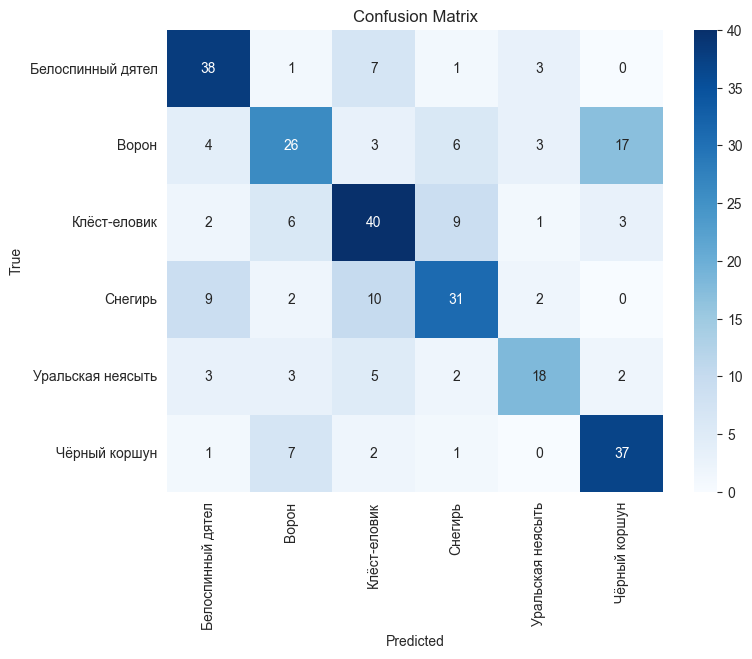

In [61]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [62]:
torch.save(model, MODELS_DIR / "bird_cnn_full.pth")